# 1. IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 2. LOAD DATA

In [2]:
# Đường dẫn file trên Kaggle
books_path = "/kaggle/input/books-dataset/books_data/books.csv"
ratings_path = "/kaggle/input/books-dataset/books_data/ratings.csv"

# Load với xử lý flexible
def load_data(file_path):
    """Load CSV với nhiều cách xử lý delimiter"""
    try:
        df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
        return df
    except:
        try:
            df = pd.read_csv(file_path, sep=';', encoding='latin-1', 
                           on_bad_lines='skip', low_memory=False)
            return df
        except Exception as e:
            print(f"Error: {e}")
            return None

books = load_data(books_path)
ratings = load_data(ratings_path)

# Xử lý CSV 1 cột
if books.shape[1] == 1:
    col_name = books.columns[0]
    books = books[col_name].astype(str).str.split(';', expand=True)
    books.columns = ["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", 
                     "Publisher", "Image-URL-S", "Image-URL-M", "Image-URL-L"]

if ratings.shape[1] == 1:
    col_name = ratings.columns[0]
    ratings = ratings[col_name].astype(str).str.split(';', expand=True)
    ratings.columns = ["User-ID", "ISBN", "Book-Rating"]

print(f"\nBooks shape: {books.shape}")
print(f"Ratings shape: {ratings.shape}")


Books shape: (271360, 8)
Ratings shape: (1149780, 3)


## Input / Output

### Input
- `Books.csv`: thông tin sách (ISBN, title, author, year, publisher, image URLs)
- `Ratings.csv`: tương tác (User-ID, ISBN, Book-Rating)

### Output
- Hàm gợi ý trả về **Top-N** sách cho mỗi `User-ID` mà user chưa đánh giá,
  kèm `pred_score` và thông tin cơ bản của sách (title, author,...).


# 3. DATA PREPROCESSING

## 3.1 Clean data

In [3]:
for col in books.columns:
    if books[col].dtype == 'object':
        books[col] = books[col].astype(str).str.replace('"', '').str.strip()

for col in ratings.columns:
    if ratings[col].dtype == 'object':
        ratings[col] = ratings[col].astype(str).str.replace('"', '').str.strip()

## 3.2 Convert data types

In [4]:
ratings["User-ID"] = pd.to_numeric(ratings["User-ID"], errors='coerce')
ratings["Book-Rating"] = pd.to_numeric(ratings["Book-Rating"], errors='coerce')
books["Year-Of-Publication"] = pd.to_numeric(books["Year-Of-Publication"], errors='coerce')

## 3.3 Drop missing values

In [5]:
books = books.dropna(subset=["ISBN", "Book-Title"])
ratings = ratings.dropna(subset=["User-ID", "ISBN", "Book-Rating"])

print(f"  Books: {books.shape[0]:,} rows")
print(f"  Ratings: {ratings.shape[0]:,} rows")

  Books: 271,360 rows
  Ratings: 1,149,780 rows


In [6]:
# Filter ratings > 0 (explicit feedback)
print(f"\n Before filtering:")
print(f"Total ratings: {len(ratings):,}")
print(f"Rating = 0: {(ratings['Book-Rating'] == 0).sum():,}")
print(f"Rating > 0: {(ratings['Book-Rating'] > 0).sum():,}")

# TẠO ratings_explicit Ở ĐÂY
ratings_explicit = ratings[ratings["Book-Rating"] > 0].copy()

print(f"\n Explicit ratings (>0): {len(ratings_explicit):,}")


# LỌC SPARSE USERS/ITEMS
# Đếm số rating của mỗi user và item
user_counts = ratings_explicit["User-ID"].value_counts()
item_counts = ratings_explicit["ISBN"].value_counts()

print(f"\n Before filtering:")
print(f"Unique users: {len(user_counts):,}")
print(f"Unique books: {len(item_counts):,}")
print(f"Total ratings: {len(ratings_explicit):,}")

# Hiển thị phân bố
print(f"\n Distribution:")
print(f"Users với 1 rating: {(user_counts == 1).sum():,}")
print(f"Users với 2-5 ratings: {((user_counts >= 2) & (user_counts <= 5)).sum():,}")
print(f"Users với 6-10 ratings: {((user_counts >= 6) & (user_counts <= 10)).sum():,}")
print(f"Users với >10 ratings: {(user_counts > 10).sum():,}")

# Set minimum thresholds
MIN_USER_RATINGS = 10
MIN_ITEM_RATINGS = 10

print(f"\n Filtering with thresholds:")
print(f"MIN_USER_RATINGS = {MIN_USER_RATINGS}")
print(f"MIN_ITEM_RATINGS = {MIN_ITEM_RATINGS}")

# Lọc users và items đủ điều kiện
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
popular_items = item_counts[item_counts >= MIN_ITEM_RATINGS].index

filtered_ratings = ratings_explicit[
    ratings_explicit["User-ID"].isin(active_users) & 
    ratings_explicit["ISBN"].isin(popular_items)
].copy()

print(f"\n After filtering:")
print(f"Users: {filtered_ratings['User-ID'].nunique():,}")
print(f"Books: {filtered_ratings['ISBN'].nunique():,}")
print(f"Ratings: {len(filtered_ratings):,}")

# Tính sparsity
n_users = filtered_ratings['User-ID'].nunique()
n_items = filtered_ratings['ISBN'].nunique()
sparsity = 1 - len(filtered_ratings) / (n_users * n_items)
print(f"  Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")


# CREATE USER/ITEM MAPPINGS
user_id_map = {uid: idx for idx, uid in enumerate(filtered_ratings["User-ID"].unique())}
item_id_map = {isbn: idx for idx, isbn in enumerate(filtered_ratings["ISBN"].unique())}

filtered_ratings["user_idx"] = filtered_ratings["User-ID"].map(user_id_map)
filtered_ratings["item_idx"] = filtered_ratings["ISBN"].map(item_id_map)

print(f" Encoded: {n_users} users × {n_items} items")

# Verify no NaN in mappings
assert filtered_ratings["user_idx"].isna().sum() == 0, "NaN in user_idx!"
assert filtered_ratings["item_idx"].isna().sum() == 0, "NaN in item_idx!"
print(" Mappings verified - no NaN values")


 Before filtering:
Total ratings: 1,149,780
Rating = 0: 716,109
Rating > 0: 433,671

 Explicit ratings (>0): 433,671

 Before filtering:
Unique users: 77,805
Unique books: 185,972
Total ratings: 433,671

 Distribution:
Users với 1 rating: 45,382
Users với 2-5 ratings: 20,404
Users với 6-10 ratings: 5,364
Users với >10 ratings: 6,655

 Filtering with thresholds:
MIN_USER_RATINGS = 10
MIN_ITEM_RATINGS = 10

 After filtering:
Users: 6,837
Books: 5,640
Ratings: 90,556
  Sparsity: 0.9977 (99.77%)
 Encoded: 6837 users × 5640 items
 Mappings verified - no NaN values


### 1) Đọc dữ liệu & chuẩn hóa định dạng
- Dataset có thể gặp tình huống CSV dùng dấu `;` hoặc có dấu `"` trong text.
- Chuẩn hóa kiểu dữ liệu:
  - `User-ID` → số
  - `Book-Rating` → số
  - `Year-Of-Publication` → số (nếu cần)

### 2) Xử lý rating = 0
Trong dataset này, nhiều bản ghi có `Book-Rating = 0`.  
Thực tế, `0` thường mang nghĩa **không đánh giá/implicit**, không phản ánh mức độ thích thật sự.
- Với bài toán **explicit recommendation**, ta thường:
  - **lọc `Book-Rating > 0`** để mô hình học từ đánh giá thực sự.

### 3) Giảm độ thưa (Sparsity filtering)
Ma trận user–item rất thưa (đa số user chỉ rate rất ít sách).  
Để mô hình học ổn định và giảm nhiễu, ta lọc:
- User có ít hơn `MIN_USER_RATINGS` tương tác
- Sách có ít hơn `MIN_ITEM_RATINGS` lượt đánh giá

Kết quả: dữ liệu “chất lượng hơn” để train Collaborative Filtering.

# 4. EXPLORATORY DATA ANALYSIS (EDA)


 Rating Distribution:
count    90556.000000
mean         7.849618
std          1.771379
min          1.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: Book-Rating, dtype: float64


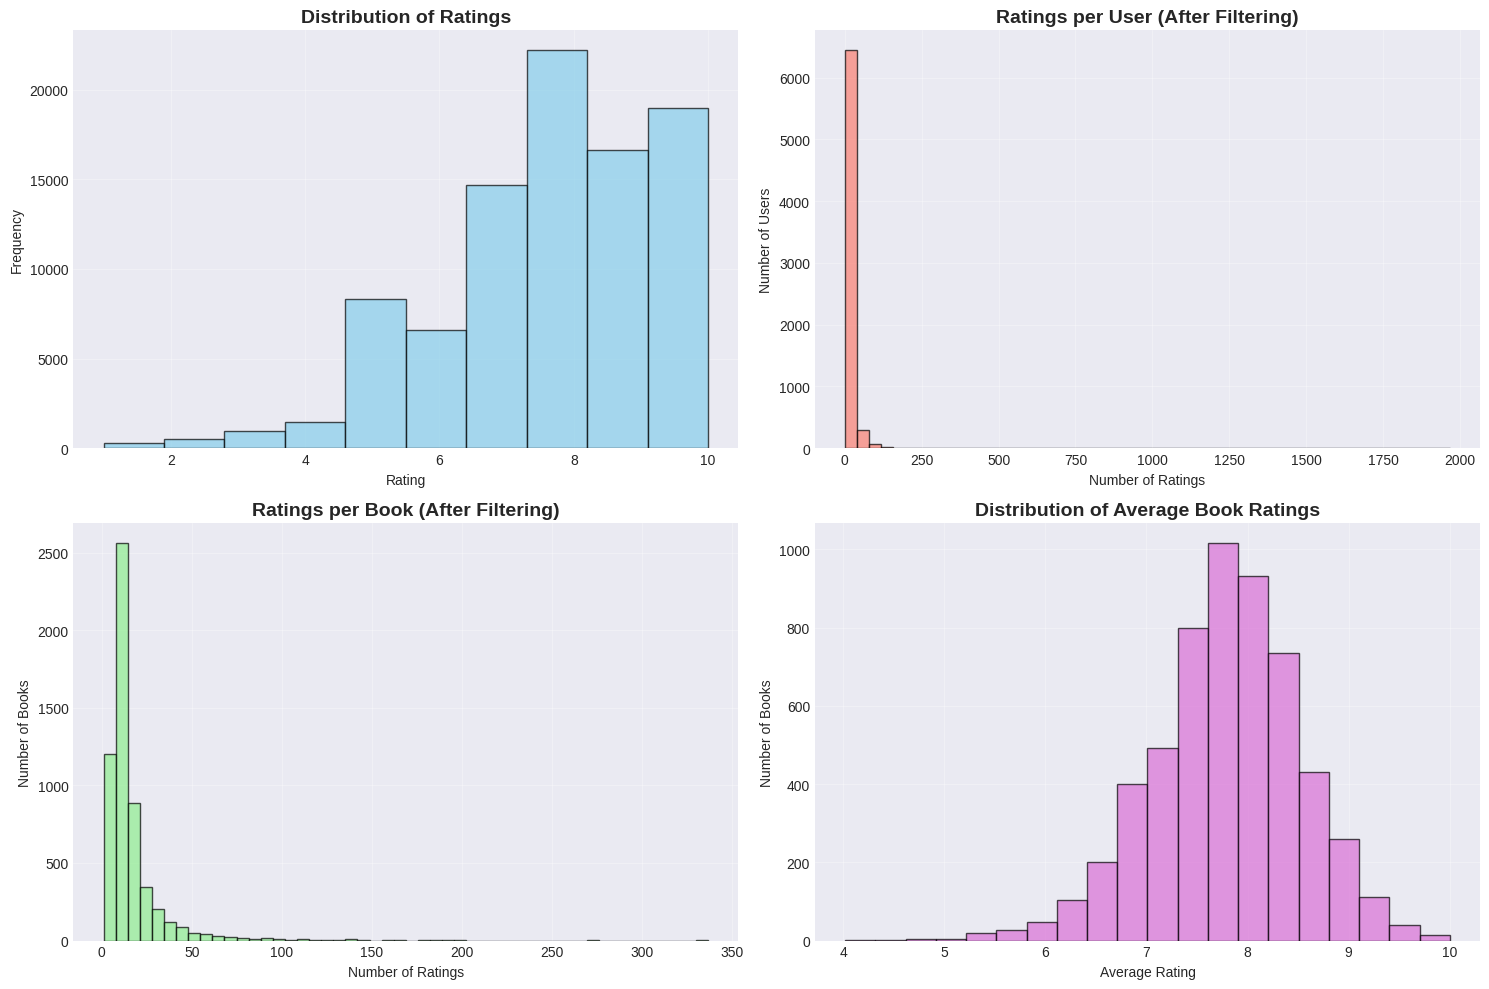

In [7]:
print("\n Rating Distribution:")
print(filtered_ratings["Book-Rating"].describe())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating distribution
axes[0, 0].hist(filtered_ratings["Book-Rating"], bins=10, 
                edgecolor='black', color='skyblue', alpha=0.7)
axes[0, 0].set_title("Distribution of Ratings", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(alpha=0.3)

# 2. Ratings per user
user_rating_counts = filtered_ratings.groupby("User-ID").size()
axes[0, 1].hist(user_rating_counts, bins=50, edgecolor='black', color='salmon', alpha=0.7)
axes[0, 1].set_title("Ratings per User (After Filtering)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Number of Ratings")
axes[0, 1].set_ylabel("Number of Users")
axes[0, 1].grid(alpha=0.3)

# 3. Ratings per book
book_rating_counts = filtered_ratings.groupby("ISBN").size()
axes[1, 0].hist(book_rating_counts, bins=50, edgecolor='black', color='lightgreen', alpha=0.7)
axes[1, 0].set_title("Ratings per Book (After Filtering)", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("Number of Books")
axes[1, 0].grid(alpha=0.3)

# 4. Average rating distribution
avg_ratings = filtered_ratings.groupby("ISBN")["Book-Rating"].mean()
axes[1, 1].hist(avg_ratings, bins=20, edgecolor='black', color='orchid', alpha=0.7)
axes[1, 1].set_title("Distribution of Average Book Ratings", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Average Rating")
axes[1, 1].set_ylabel("Number of Books")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("eda_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Khám phá dữ liệu (EDA)

Mục tiêu EDA:
- Nắm quy mô dữ liệu: số user, số sách, số tương tác
- Quan sát phân phối điểm rating
- Xem top sách/tác giả được đánh giá nhiều
- Ước lượng độ thưa của ma trận user–item

EDA giúp kiểm tra:
- dữ liệu có bị lệch (rating tập trung 8–10 hay rải đều?)
- có nhiều rating=0 hay không (để quyết định xử lý)
- độ thưa cao đến mức nào (để chọn mô hình phù hợp)

# 5. MODEL 1: POPULARITY-BASED BASELINE

In [8]:
# Tính popularity với điều kiện minimum ratings
MIN_RATINGS_FOR_POPULARITY = 20  # Chỉ xét sách có >= 20 ratings

popularity_df = (filtered_ratings.groupby("ISBN")
                 .agg({"Book-Rating": ["count", "mean"]})
                 .reset_index())
popularity_df.columns = ["ISBN", "rating_count", "avg_rating"]

# Filter: chỉ xét sách đủ phổ biến
popularity_df = popularity_df[popularity_df["rating_count"] >= MIN_RATINGS_FOR_POPULARITY].copy()

# Score = avg_rating × log(count + 1)
# Công thức này cân bằng giữa chất lượng (avg) và số lượng (count)
popularity_df["popularity_score"] = (
    popularity_df["avg_rating"] * np.log1p(popularity_df["rating_count"])
)

popularity_df = popularity_df.sort_values("popularity_score", ascending=False)

# Top 20
top_20_popular = popularity_df.head(20).merge(
    books[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication"]], 
    on="ISBN", how="left"
)

print(f"\n Top 20 Popular Books (min_ratings={MIN_RATINGS_FOR_POPULARITY}):")
print(top_20_popular[["Book-Title", "Book-Author", "rating_count", 
                       "avg_rating", "popularity_score"]].to_string())

top_20_popular.to_csv("baseline_popular_books.csv", index=False)
print("\n Baseline saved!")


 Top 20 Popular Books (min_ratings=20):
                                                                   Book-Title    Book-Author  rating_count  avg_rating  popularity_score
0                                                           The Da Vinci Code      Dan Brown           276    8.565217         48.170933
1                                                   The Lovely Bones: A Novel   Alice Sebold           337    8.246291         48.018530
2            Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))  J. K. Rowling           184    8.994565         46.954831
3                          Harry Potter and the Order of the Phoenix (Book 5)  J. K. Rowling           158    9.056962         45.908873
4                                                                         NaN            NaN           179    8.636872         44.850901
5                                                     The Secret Life of Bees  Sue Monk Kidd           179    8.581006         44.560792


## Thuật toán / Mô hình 1: Popularity-based (Baseline)

### Ý tưởng
Gợi ý những cuốn sách “được cộng đồng đánh giá tốt”, không cá nhân hóa theo từng user.

### Cách tính điểm phổ biến (ví dụ)
- `avg_rating`: điểm trung bình của sách
- `n_ratings`: số lượt đánh giá
- `score = avg_rating * log(1 + n_ratings)` để ưu tiên sách vừa **điểm cao** vừa **nhiều người đánh giá**

### Vai trò trong bài
- Là mô hình baseline để so sánh với Collaborative Filtering.
- Nhanh, dễ triển khai, nhưng **không cá nhân hóa**.

# 6. USER-BASED TRAIN-TEST SPLIT

In [9]:
def user_based_train_test_split(data, test_size=0.2, random_state=42):
    """
    Split dữ liệu theo user để tránh leakage
    Mỗi user sẽ có một số ratings vào test set
    """
    np.random.seed(random_state)
    
    train_list = []
    test_list = []
    
    for user_id in data["User-ID"].unique():
        user_data = data[data["User-ID"] == user_id]
        
        # Shuffle ratings của user
        user_data_shuffled = user_data.sample(frac=1, random_state=random_state)
        
        # Split
        n_test = max(1, int(len(user_data) * test_size))
        
        test_list.append(user_data_shuffled.iloc[:n_test])
        train_list.append(user_data_shuffled.iloc[n_test:])
    
    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    
    return train_df, test_df

# Split data
train_data, test_data = user_based_train_test_split(
    filtered_ratings[["User-ID", "ISBN", "Book-Rating", "user_idx", "item_idx"]], 
    test_size=0.2, 
    random_state=42
)

print(f"\n User-based split:")
print(f"Training ratings: {len(train_data):,}")
print(f"Test ratings: {len(test_data):,}")
print(f"Users in train: {train_data['User-ID'].nunique():,}")
print(f"Users in test: {test_data['User-ID'].nunique():,}")
print(f"Overlap users: {len(set(train_data['User-ID']) & set(test_data['User-ID'])):,}")


 User-based split:
Training ratings: 73,156
Test ratings: 17,400
Users in train: 6,308
Users in test: 6,837
Overlap users: 6,308


# 7. PYTORCH DATASET & DATALOADER

In [10]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.users = torch.LongTensor(data["user_idx"].values)
        self.items = torch.LongTensor(data["item_idx"].values)
        self.ratings = torch.FloatTensor(data["Book-Rating"].values)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n DataLoaders created (batch_size={BATCH_SIZE})")


 DataLoaders created (batch_size=1024)


# 8. MODEL 2: MATRIX FACTORIZATION WITH PYTORCH

In [11]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=100):
        super(MatrixFactorization, self).__init__()
        
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.user_biases = nn.Embedding(n_users, 1)
        self.item_biases = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        
        # Initialize
        nn.init.normal_(self.user_factors.weight, std=0.01)
        nn.init.normal_(self.item_factors.weight, std=0.01)
        nn.init.zeros_(self.user_biases.weight)
        nn.init.zeros_(self.item_biases.weight)
    
    def forward(self, user, item):
        user_embedding = self.user_factors(user)
        item_embedding = self.item_factors(item)
        
        dot = (user_embedding * item_embedding).sum(dim=1, keepdim=True)
        
        prediction = (dot + 
                     self.user_biases(user) + 
                     self.item_biases(item) + 
                     self.global_bias)
        
        return prediction.squeeze()

# Initialize model
N_FACTORS = 100
model = MatrixFactorization(n_users, n_items, N_FACTORS).to(device)

print(f"\n Model:")
print(f"Users: {n_users}, Items: {n_items}")
print(f"Embedding dim: {N_FACTORS}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


 Model:
Users: 6837, Items: 5640
Embedding dim: 100
Parameters: 1,260,178


## Thuật toán / Mô hình 2: Collaborative Filtering (Matrix Factorization)

### Bài toán
Dựa vào lịch sử rating, học ra “sở thích tiềm ẩn” của user và “đặc trưng tiềm ẩn” của sách.

### Ý tưởng Matrix Factorization
- Mỗi user được biểu diễn bởi 1 vector embedding `u`
- Mỗi sách được biểu diễn bởi 1 vector embedding `v`
- Điểm dự đoán:
  - `pred = dot(u, v) + bias_user + bias_item + global_bias`

### Lý do chọn MF
- Phù hợp dữ liệu rating (explicit feedback)
- Cá nhân hóa tốt
- Triển khai đơn giản, có thể train nhanh trên Kaggle (CPU/GPU)


# 9. TRAINING

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for users, items, ratings in loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(ratings)
    
    return total_loss / len(loader.dataset)

# 10. EVALUATE WITH RMSE & MAE


Training for 20 epochs...

Epoch  1/20 | Train Loss: 63.7175 | Test RMSE: 7.0755 | Test MAE: 6.8514
Epoch  5/20 | Train Loss: 31.9356 | Test RMSE: 5.2818 | Test MAE: 4.8254
Epoch 10/20 | Train Loss: 5.3806 | Test RMSE: 2.8217 | Test MAE: 2.1489
Epoch 15/20 | Train Loss: 2.4057 | Test RMSE: 2.2689 | Test MAE: 1.6264
Epoch 20/20 | Train Loss: 1.7898 | Test RMSE: 2.1114 | Test MAE: 1.4848

Training completed!

Final Metrics:
RMSE: 2.1114
MAE: 1.4848


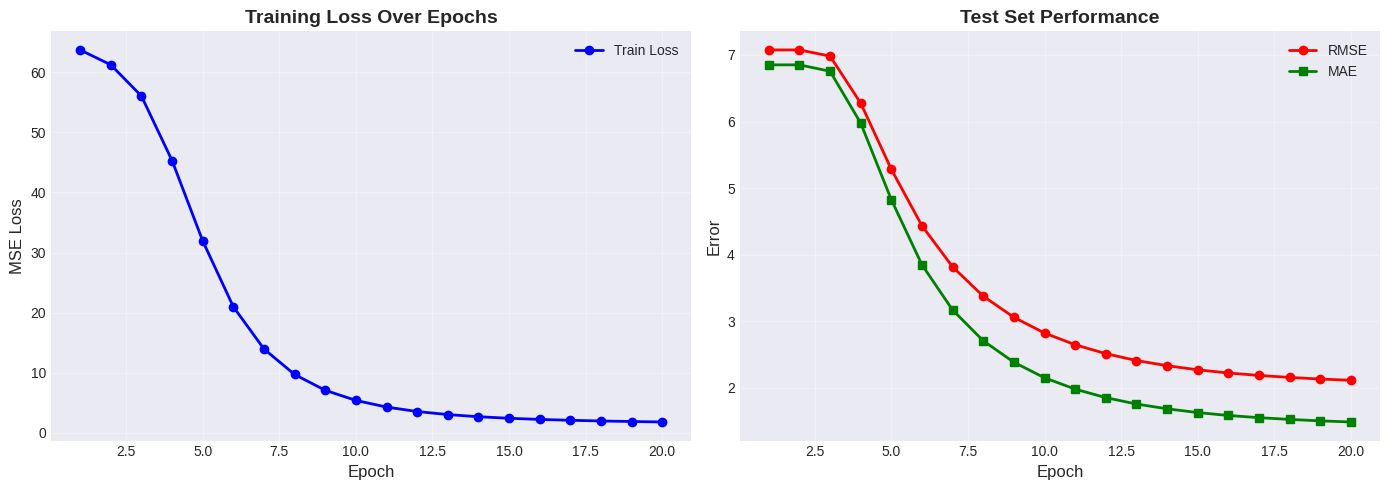

In [13]:
def evaluate(model, loader, device):
    """Evaluate với RMSE và MAE"""
    model.eval()
    predictions_list = []
    actuals_list = []
    
    with torch.no_grad():
        for users, items, ratings in loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = model(users, items)
            
            predictions_list.append(predictions.cpu().numpy())
            actuals_list.append(ratings.cpu().numpy())
    
    predictions_array = np.concatenate(predictions_list)
    actuals_array = np.concatenate(actuals_list)
    
    # Clip predictions to valid range [1, 10]
    predictions_array = np.clip(predictions_array, 1, 10)
    
    rmse = np.sqrt(mean_squared_error(actuals_array, predictions_array))
    mae = mean_absolute_error(actuals_array, predictions_array)
    
    return rmse, mae, predictions_array, actuals_array

# Training loop
N_EPOCHS = 20
train_losses = []
test_rmses = []
test_maes = []

print(f"\nTraining for {N_EPOCHS} epochs...\n")

for epoch in range(N_EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_rmse, test_mae, _, _ = evaluate(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_rmses.append(test_rmse)
    test_maes.append(test_mae)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}/{N_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test RMSE: {test_rmse:.4f} | "
              f"Test MAE: {test_mae:.4f}")

print(f"\nTraining completed!")
print(f"\nFinal Metrics:")
print(f"RMSE: {test_rmses[-1]:.4f}")
print(f"MAE: {test_maes[-1]:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, N_EPOCHS+1), train_losses, 'b-o', label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, N_EPOCHS+1), test_rmses, 'r-o', label='RMSE', linewidth=2, markersize=6)
axes[1].plot(range(1, N_EPOCHS+1), test_maes, 'g-s', label='MAE', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Test Set Performance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_history.png", dpi=300, bbox_inches='tight')
plt.show()

# 11. TOP-K EVALUATION (Precision@K, Recall@K)

In [14]:
def calculate_precision_recall_at_k(model, data, k=10, threshold=7):
    """
    Calculate Precision@K and Recall@K
    
    Precision@K: Tỷ lệ sách relevant trong top-K
    Recall@K: Tỷ lệ sách relevant được tìm thấy trong top-K
    """
    model.eval()
    user_metrics = {}
    
    for user_idx in data["user_idx"].unique():
        user_data = data[data["user_idx"] == user_idx]
        
        if len(user_data) < k:
            continue
        
        with torch.no_grad():
            users_tensor = torch.LongTensor(user_data["user_idx"].values).to(device)
            items_tensor = torch.LongTensor(user_data["item_idx"].values).to(device)
            predictions = model(users_tensor, items_tensor).cpu().numpy()
        
        actual_ratings = user_data["Book-Rating"].values
        
        # Sort by predicted rating (descending)
        sorted_indices = np.argsort(predictions)[::-1]
        top_k_indices = sorted_indices[:k]
        
        # Relevant items (actual rating >= threshold)
        relevant_items = actual_ratings >= threshold
        n_relevant = relevant_items.sum()
        
        if n_relevant == 0:
            continue
        
        # Recommended relevant items in top-k
        recommended_relevant = relevant_items[top_k_indices].sum()
        
        # Metrics
        precision = recommended_relevant / k
        recall = recommended_relevant / n_relevant
        
        user_metrics[user_idx] = {"precision": precision, "recall": recall}
    
    if len(user_metrics) == 0:
        return 0, 0
    
    avg_precision = np.mean([m["precision"] for m in user_metrics.values()])
    avg_recall = np.mean([m["recall"] for m in user_metrics.values()])
    
    return avg_precision, avg_recall

# Calculate for k=5 and k=10
print("\nCalculating Precision@K & Recall@K...")
p_at_5, r_at_5 = calculate_precision_recall_at_k(model, test_data, k=5, threshold=7)
p_at_10, r_at_10 = calculate_precision_recall_at_k(model, test_data, k=10, threshold=7)

print(f"\nTop-K Recommendation Metrics (threshold=7):")
print(f"Precision@5:  {p_at_5:.4f}")
print(f"Recall@5:     {r_at_5:.4f}")
print(f"Precision@10: {p_at_10:.4f}")
print(f"Recall@10:    {r_at_10:.4f}")


Calculating Precision@K & Recall@K...

Top-K Recommendation Metrics (threshold=7):
Precision@5:  0.8659
Recall@5:     0.6962
Precision@10: 0.8725
Recall@10:    0.7613


## Đánh giá mô hình (Evaluation)

Bài toán có 2 kiểu đánh giá:

### 1) Rating prediction metrics (hồi quy điểm)
- **RMSE**: phạt mạnh sai số lớn (đánh giá chất lượng dự đoán rating)
- **MAE**: sai số trung bình tuyệt đối (dễ diễn giải)

### 2) Top-K recommendation metrics (xếp hạng gợi ý)
Ta coi một item là “relevant” nếu `rating thật >= threshold` (ví dụ 8).
- **Precision@K**: trong Top-K gợi ý, có bao nhiêu item thật sự relevant
- **Recall@K**: trong tất cả item relevant của user, mô hình tìm được bao nhiêu trong Top-K

Mục tiêu: MF phải tốt hơn baseline về khả năng cá nhân hóa (Top-K).


# 12. RECOMMENDATION FUNCTION

In [15]:
# Reverse mappings
idx_to_user = {idx: uid for uid, idx in user_id_map.items()}
idx_to_isbn = {idx: isbn for isbn, idx in item_id_map.items()}

def recommend_books(user_id, model, n=10, show_already_rated=True):
    """
    Recommend top N books for a given user
    
    IMPROVED: Đảm bảo KHÔNG gợi ý sách user đã đọc
    """
    if user_id not in user_id_map:
        print(f"User {user_id} not found!")
        return None
    
    user_idx = user_id_map[user_id]
    
    # Get books user has ALREADY rated (phải loại bỏ)
    user_rated_books = set(filtered_ratings[filtered_ratings["User-ID"] == user_id]["ISBN"])
    
    if show_already_rated:
        print(f"\nUser {user_id} đã đánh giá: {len(user_rated_books)} sách")
    
    # Candidate items (chưa được user rating)
    all_item_indices = list(range(n_items))
    candidate_indices = [idx for idx in all_item_indices 
                        if idx_to_isbn[idx] not in user_rated_books]
    
    print(f"Số sách có thể gợi ý: {len(candidate_indices):,}")
    
    # Predict ratings
    model.eval()
    with torch.no_grad():
        users_tensor = torch.LongTensor([user_idx] * len(candidate_indices)).to(device)
        items_tensor = torch.LongTensor(candidate_indices).to(device)
        predictions = model(users_tensor, items_tensor).cpu().numpy()
    
    # Get top N
    top_n_indices = np.argsort(predictions)[::-1][:n]
    top_n_item_indices = [candidate_indices[i] for i in top_n_indices]
    top_n_predictions = [predictions[i] for i in top_n_indices]
    top_n_isbns = [idx_to_isbn[i] for i in top_n_item_indices]
    
    # Create result
    result_df = pd.DataFrame({
        "ISBN": top_n_isbns,
        "Predicted_Rating": top_n_predictions
    })
    
    result_df = result_df.merge(
        books[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"]], 
        on="ISBN", how="left"
    )
    
    return result_df

# 13. TESTING - DEMO RECOMMENDATIONS

In [16]:
# Select sample user
sample_users = filtered_ratings["User-ID"].value_counts().head(10).index
test_user_id = sample_users[0]

print(f"TESTING WITH USER ID: {test_user_id}")

# Show user's rating history
user_history = (filtered_ratings[filtered_ratings["User-ID"] == test_user_id]
                .merge(books[["ISBN", "Book-Title", "Book-Author"]], on="ISBN", how="left")
                .sort_values("Book-Rating", ascending=False))

print(f"\n5 cuốn sách được người dùng đánh giá cao nhất:")
print(user_history[["Book-Title", "Book-Author", "Book-Rating"]].head(5).to_string(index=False))

print(f"\nThống kê người dùng:")
print(f"  Total ratings: {len(user_history)}")
print(f"  Average rating: {user_history['Book-Rating'].mean():.2f}")
print(f"  Rating range: {user_history['Book-Rating'].min():.0f} - {user_history['Book-Rating'].max():.0f}")

# Generate recommendations
recommendations = recommend_books(test_user_id, model, n=10, show_already_rated=True)

print(f"\n10 cuốn sách được đề xuất hàng đầu:")
display_cols = ["Book-Title", "Book-Author", "Predicted_Rating", "Year-Of-Publication"]
print(recommendations[display_cols].to_string(index=False))

TESTING WITH USER ID: 11676

5 cuốn sách được người dùng đánh giá cao nhất:
                                              Book-Title            Book-Author  Book-Rating
Veronika Deschliesst Zu Sterben / Vernika Decides to Die           Paolo Coelho           10
                                                 Join Me          Danny Wallace           10
                                  Relato de un nÃ¡ufrago Gabriel Garcia Marquez           10
                                                     NaN                    NaN           10
            Widow's Walk (Spenser Mysteries (Hardcover))          Robert Parker           10

Thống kê người dùng:
  Total ratings: 1967
  Average rating: 7.63
  Rating range: 1 - 10

User 11676 đã đánh giá: 1967 sách
Số sách có thể gợi ý: 3,673

10 cuốn sách được đề xuất hàng đầu:
                                                  Book-Title    Book-Author  Predicted_Rating  Year-Of-Publication
                             Emma (Penguin Popular Classics) 

## Testing / Demo hệ thống gợi ý

Quy trình demo:
1) Chọn một `User-ID` có trong tập dữ liệu
2) Lấy danh sách sách user đã đánh giá (đã đọc)
3) Dự đoán điểm cho các sách user **chưa đánh giá**
4) Sắp xếp giảm dần theo `pred_score`
5) Trả về **Top-N** đề xuất kèm thông tin sách (title/author/…)


# 14. SAVE RESULTS

In [17]:
# Save model
torch.save(model.state_dict(), "matrix_factorization_model.pth")
print(" Model weights saved")

# Save metrics
metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "Precision@5", "Recall@5", "Precision@10", "Recall@10"],
    "Value": [test_rmses[-1], test_maes[-1], p_at_5, r_at_5, p_at_10, r_at_10]
})
metrics_df.to_csv("evaluation_metrics.csv", index=False)
print("Evaluation metrics saved")

# Save recommendations
recommendations.to_csv("sample_recommendations.csv", index=False)
print("Sample recommendations saved")

 Model weights saved
Evaluation metrics saved
Sample recommendations saved


## Kết quả & Kết luận

### Kết quả chính
- Baseline (Popularity): đưa ra top sách phổ biến nhất, không cá nhân hóa.
- Collaborative Filtering (MF): cá nhân hóa theo từng user, thường cải thiện Top-K.

Báo cáo các chỉ số:
- RMSE / MAE trên tập test
- Precision@5, Precision@10
- Recall@5, Recall@10

### Hạn chế
- Cold-start: user mới hoặc sách mới chưa có rating sẽ khó gợi ý tốt.
- Dữ liệu thưa: cần lọc hoặc thêm regularization.